In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white") 
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans

%matplotlib inline

In [8]:
# le dropna() permet de supprimer les pays pour lesquels il manque des informations
WGI_complet = pd.read_csv("./src/wgi2019.csv").dropna()
WGI_complet

,Country,Code,Voice and Accountability,Political Stability and Absence of Violence/Terrorism,Government Effectiveness,Regulatory Quality,Rule of Law,Control of Corruption
0,Aruba,ABW,1.294189,1.357372,1.029933,0.857360,1.263128,1.217238
1,Andorra,ADO,1.139154,1.615139,1.908749,1.228176,1.579939,1.234392
2,Afghanistan,AFG,-0.988032,-2.649407,-1.463875,-1.120555,-1.713527,-1.401076
3,Angola,AGO,-0.777283,-0.311101,-1.117144,-0.893871,-1.054343,-1.054683
5,Albania,ALB,0.151805,0.118570,-0.061331,0.274380,-0.411179,-0.528758
...,...,...,...,...,...,...,...,...
209,Serbia,SRB,0.026626,-0.091665,0.019079,0.113867,-0.119070,-0.445551
210,South Africa,ZAF,0.670388,-0.217931,0.367380,0.156172,-0.076408,0.084924
211,"Congo, Dem. Rep.",ZAR,-1.365966,-1.808007,-1.627429,-1.509667,-1.786088,-1.538931
212,Zambia,ZMB,-0.286199,-0.102216,-0.675215,-0.554269,-0.462069,-0.640345


### ACP

On va `fit()` les données (variables uniquement quantitatives).

Si l'on souhaite une ACP normée (ce qui n'est pas le cas ici), il nous faut standardiser les données en amont, avec par exemple la fonction scale() du sous-module preprocessing (importée aussi ici). Bien évidemment, il ne faut passer que des variables quantitatives, sans données manquantes.

In [9]:
# suppression des colonnes non numériques
WGI_num = WGI_complet.drop(columns = ["Country", "Code"])
pca = PCA()
pca.fit(WGI_num)

PCA()

#### Variance expliquée

L'objet `pca` comprend maintenant un certain nombre d'objets et de fonctions. Le premier objet est le tableau des variances expliquées (`explained_variance_` - proportionnelles aux valeurs propres) par chaque dimension, et le ratio (proportion) de variance expliquée par dimension (`explained_variance_ratio_`).

In [10]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[5.04959218 0.41467898 0.30759716 0.12165034 0.04965011 0.04069217]
[0.84386857 0.06929957 0.05140446 0.02032974 0.00829734 0.00680032]


Bien évidemment, il est possible (et préférable) de faire un tableau récapitulatif, avec les variances expliquées, les proportions de variance expliquée simples et cumulées. Voici un petit code permettant de faire ceci.

In [16]:
eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(6)], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
eig

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,Dim1,5.049592,84.0,84.0
1,Dim2,0.414679,7.0,91.0
2,Dim3,0.307597,5.0,96.0
3,Dim4,0.121650,2.0,98.0
4,Dim5,0.049650,1.0,99.0
5,Dim6,0.040692,1.0,100.0


L'idée est de représenter graphiquement ces proportions de variances expliquées (qu'on passe en pourcentage par convenance).

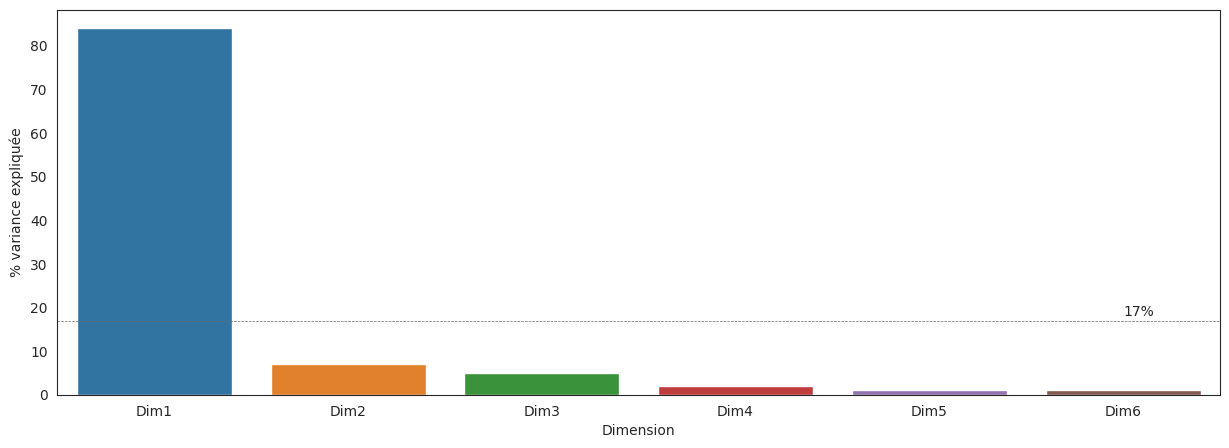

In [17]:
plt.figure(figsize=(15,5)) 
sns.barplot(data=eig, x="Dimension", y="% variance expliquée")
plt.text(5, 18, "17%")
plt.axhline(y=17, linewidth=.5, color="dimgray", linestyle="--") # ligne 17 = 100 / 6 (nb dimensions)
plt.show();

On remarque ici qu'avec seulement deux dimensions suffisent à expliquer 91 % de la variance des données.

### Représentation des individus

Nous allons maintenant calculer les coordonnées des pays sur les dimensions, avec la fonction `transform()` de l'objet **pca**.

In [18]:
WGI_pca = pca.transform(WGI_num)

Afin de manipuler plus facilement l'objet obtenu par la suite, nous allons créer un dataframe en ne prenant que les deux premières dimensions, ainsi que le nom des pays

In [19]:
# Transformation en dataframe
WGI_pca_df = pd.DataFrame({
    "Dim1" : WGI_pca[:,0], 
    "Dim2" : WGI_pca[:,1],
    "Country" : WGI_complet["Country"]
})

# Résultat (premières lignes)
WGI_pca_df.head()

,Dim1,Dim2,Country
0,-2.921523,0.503627,Aruba
1,-3.630601,0.075195,Andorra
2,3.704414,-0.846353,Afghanistan
3,2.083839,0.446336,Angola
5,0.137824,0.175896,Albania


Il est maintenant possible de représenter les données sur le premier plan factoriel. Dans ce graphique, il est important de noter le pourcentage de variance expliquée.

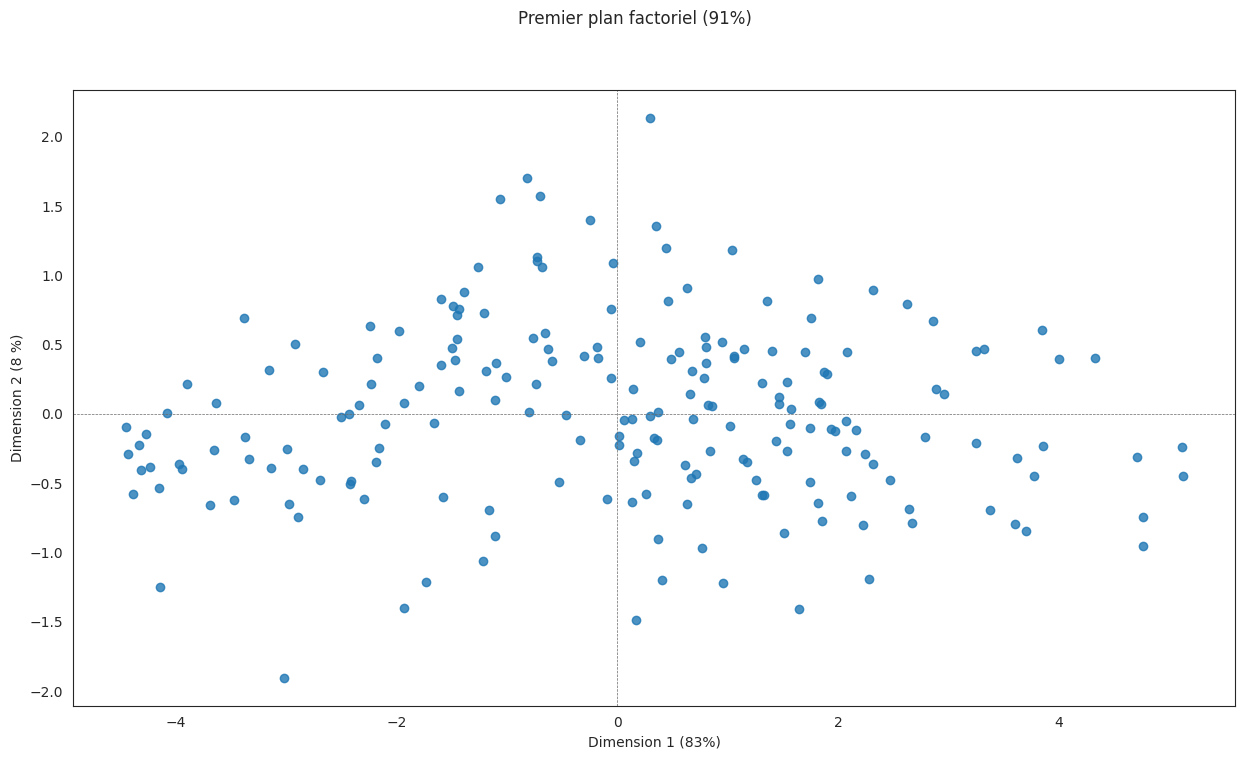

In [20]:
plt.figure(figsize=(15,8))
plt.axvline(x=0, linewidth=.5, color="dimgray", linestyle="--")
plt.axhline(y=0, linewidth=.5, color="dimgray", linestyle="--")
sns.regplot(data=WGI_pca_df, x="Dim1", y="Dim2", fit_reg=False)
plt.xlabel("Dimension 1 (83%)") # modification du nom de l'axe X
plt.ylabel("Dimension 2 (8 %)") # idem pour axe Y
plt.suptitle("Premier plan factoriel (91%)") # titre général
plt.show()

Dans ce même graphique, on veut repérer les individus aux extrêmes. Ci-dessous, nous affichons donc les noms des pays ayant des valeurs absolues élevées pour chaque composante.